### Import Library

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    precision_score,
    recall_score,
)
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import warnings

warnings.filterwarnings("ignore")

### Load data

In [ ]:
# Load dataset
data = pd.read_csv("data/Tempat-Wisata-Toba-Preprocessing.csv")

### Preprocessing Dataset

In [ ]:
# Preprocessing
def preprocess_data(data):
    data = data.dropna()
    data = data.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
    scaler = MinMaxScaler()
    data["NormalRating"] = scaler.fit_transform(data[["Rating"]])
    le_user = LabelEncoder()
    le_place = LabelEncoder()
    data["ReviewerId"] = le_user.fit_transform(data["ReviewerId"])
    data["PlaceID"] = le_place.fit_transform(data["PlaceID"])
    train, test = train_test_split(data, test_size=0.3, random_state=42)
    test, val = train_test_split(test, test_size=0.5, random_state=42)
    return train, test, val, le_user, le_place

###  Collaborative Filtering with SVD

In [ ]:
# Collaborative Filtering
def collaborative_filtering_tuning(train):
    reader = Reader(rating_scale=(0, 1))
    data_surprise = Dataset.load_from_df(
        train[["ReviewerId", "PlaceID", "NormalRating"]], reader
    )
    param_grid = {
        "n_factors": [50, 100, 150],
        "n_epochs": [10, 20, 30],
        "lr_all": [0.002, 0.005, 0.01],
        "reg_all": [0.02, 0.05, 0.1],
    }
    gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)
    gs.fit(data_surprise)
    best_params = gs.best_params["rmse"]
    print(f"Best parameters for SVD: {best_params}")
    best_svd = SVD(**best_params)
    trainset = data_surprise.build_full_trainset()
    best_svd.fit(trainset)
    return best_svd

### Content-Based Filtering with TF-IDF and Cosine Similarity

In [ ]:
# Content-Based Filtering
def content_based_filtering_tuning(train):
    factory = StopWordRemoverFactory()
    stopwords = factory.get_stop_words()
    params = {
        "max_features": [100, 500, 1000],
        "ngram_range": [(1, 1), (1, 2), (1, 3)],
        "stop_words": [stopwords, None],
    }
    reviews = train["Reviews"]
    best_tfidf = None
    best_score = -1
    for max_features in params["max_features"]:
        for ngram_range in params["ngram_range"]:
            for stop_words in params["stop_words"]:
                tfidf = TfidfVectorizer(
                    max_features=max_features,
                    ngram_range=ngram_range,
                    stop_words=stop_words,
                )
                try:
                    tfidf_matrix = tfidf.fit_transform(reviews)
                    score = cosine_similarity(tfidf_matrix).mean()
                    if score > best_score:
                        best_score = score
                        best_tfidf = tfidf
                except Exception as e:
                    print(e)
    print(f"Best parameters for TF-IDF: {best_tfidf.get_params()}")
    tfidf_matrix = best_tfidf.fit_transform(reviews)
    cosine_sim = cosine_similarity(tfidf_matrix)
    return cosine_sim, best_tfidf

### Hybrid Recommendation

In [ ]:
# hybrid_recommendation
def hybrid_recommendation(
    predictions, cosine_sim, svd, val, cf_weight=0.7, cb_weight=0.3
):
    # Predict rating
    val["PredictedRating"] = val.apply(
        lambda x: svd.predict(x["ReviewerId"], x["PlaceID"]).est, axis=1
    )

    hybrid_scores = []
    for i, row in val.iterrows():
        cb_score = cosine_sim[row["PlaceID"]].mean()
        cf_score = row["PredictedRating"]
        hybrid_score = cf_weight * cf_score + cb_weight * cb_score
        hybrid_scores.append(hybrid_score)

    val["HybridScore"] = hybrid_scores
    return val

### Evaluation - Ranking Based

In [ ]:
# Evaluation - Ranking Based
def evaluate_ranking_based(val):
    val["Relevant"] = val["NormalRating"] >= 0.5
    val["Recommended"] = val["HybridScore"] >= 0.5
    precision = precision_score(val["Relevant"], val["Recommended"])
    recall = recall_score(val["Relevant"], val["Recommended"])
    val = val.sort_values("HybridScore", ascending=False)
    val["Rank"] = range(1, len(val) + 1)
    val["CumulativeRelevant"] = val["Relevant"].cumsum()
    val["PrecisionAtK"] = val["CumulativeRelevant"] / val["Rank"]
    map_score = val.loc[val["Relevant"], "PrecisionAtK"].mean()
    return precision, recall, map_score

### Evaluation - Rating Based

In [ ]:
# Evaluation - Rating Based
def evaluate_rating_based(val):
    rmse = np.sqrt(mean_squared_error(val["NormalRating"], val["HybridScore"]))
    mae = mean_absolute_error(val["NormalRating"], val["HybridScore"])
    return rmse, mae

### Pemanggilan Fungsi

In [ ]:
train, test, val, le_user, le_place = preprocess_data(data)

svd = collaborative_filtering_tuning(train)

cosine_sim, tfidf = content_based_filtering_tuning(train)

val = hybrid_recommendation(val, cosine_sim, svd, val, cf_weight=0.7, cb_weight=0.3)

precision, recall, map_score = evaluate_ranking_based(val)
rmse, mae = evaluate_rating_based(val)

Best parameters for SVD: {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}
Best parameters for TF-IDF: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': 100, 'min_df': 1, 'ngram_range': (1, 3), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': None, 'strip_accents': None, 'sublinear_tf': False, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'use_idf': True, 'vocabulary': None}


### Hasil

In [9]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"MAP: {map_score}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

Precision: 0.9640463132236441
Recall: 0.9875156054931336
MAP: 0.9779478100403161
RMSE: 0.32813284841820084
MAE: 0.30439764815020637


### Visualization

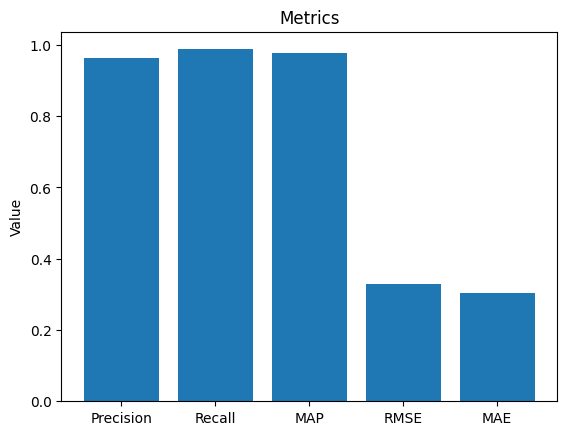

In [ ]:
# visualization  hasil evaluasi dengan chart bar
import matplotlib.pyplot as plt

metrics = ["Precision", "Recall", "MAP", "RMSE", "MAE"]
values = [precision, recall, map_score, rmse, mae]

plt.bar(metrics, values)
plt.ylabel("Value")
plt.title("Metrics")
plt.show()